## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 

<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

# Detección de sarcasmo
Para este ejercicio vas a utilizar el dataset del paper [A Large Self-Annotated Corpus for Sarcasm](https://arxiv.org/abs/1704.05579), con un millón de comentarios de Reddit, etiquetados como sarcásticos o no sarcásticos. Se pide:
1. Si hubiese missings, eliminalos




In [32]:
# some necessary imports
import os
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

#modelo
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from sklearn.metrics import classification_report

In [33]:
df = pd.read_csv('../dataNLP/train-balanced-sarcasm.csv')
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


## Tareas:
1. Analizar el conjunto de datos, realizar algunos gráficos. Este [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) podría servir como ejemplo.
2. Construir un pipeline de Tf-Idf + regresión logística para predecir sarcasmo (`label`) basado en el texto de un comentario en Reddit (`comment`).
3. Graficar las palabras/bigramas que son más predictivos de sarcasmo (puedes usar [eli5](https://github.com/TeamHG-Memex/eli5) para eso).
4. (Opcionalmente) añadir subreddits como nuevas características para mejorar el rendimiento del modelo. Aplica aquí el enfoque de Bolsa de Palabras, es decir, trata cada subreddit como una nueva característica.

## Enlaces:
- Biblioteca de aprendizaje automático [Scikit-learn](https://scikit-learn.org/stable/index.html) (también conocida como sklearn).
- Kernels sobre [regresión logística](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) y sus aplicaciones a la [clasificación de texto](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), también un [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) sobre ingeniería de características y selección de características.
- [Kernel de Kaggle](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Aproximándose a (Casi) Cualquier Problema de Procesamiento de Lenguaje Natural en Kaggle".
- [ELI5](https://github.com/TeamHG-Memex/eli5) para explicar las predicciones del modelo.


## Primera exploración

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Eliminamos los nulos

In [35]:
df.dropna(inplace=True)

Eliminamos los duplicados

In [36]:
df.drop_duplicates(subset='comment', inplace=True)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 962293 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   label           962293 non-null  int64 
 1   comment         962293 non-null  object
 2   author          962293 non-null  object
 3   subreddit       962293 non-null  object
 4   score           962293 non-null  int64 
 5   ups             962293 non-null  int64 
 6   downs           962293 non-null  int64 
 7   date            962293 non-null  object
 8   created_utc     962293 non-null  object
 9   parent_comment  962293 non-null  object
dtypes: int64(4), object(6)
memory usage: 80.8+ MB


In [38]:
df['comment'].head()

0                                           NC and NH.
1    You do know west teams play against west teams...
2    They were underdogs earlier today, but since G...
3    This meme isn't funny none of the "new york ni...
4                      I could use one of those tools.
Name: comment, dtype: object

## Balanceo dataset

Vemos que el data set esta bastante balanceado

In [39]:
df['label'].value_counts()

label
1    484099
0    478194
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='percent'>

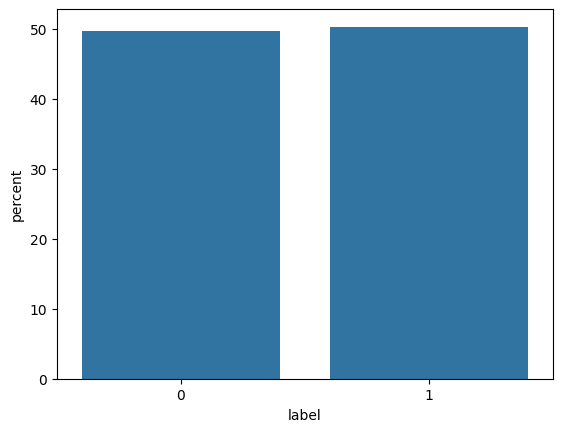

In [40]:
sns.countplot(df, x = 'label', stat='percent')

In [41]:
STOP_W = stopwords.words('english')

In [42]:
# from collections import defaultdict
# import pandas as pd
# import plotly.graph_objs as go
# from plotly.subplots import make_subplots
# import numpy as np
# import matplotlib.pyplot as plt
# import plotly.tools as tools
# import plotly.io as py

# df1 = df[df["label"]==1]
# df0 = df[df["label"]==0]

# ## custom function for ngram generation ##
# def generate_ngrams(text, n_gram=1):
#     token = [token for token in text.lower().split(" ") if token != "" if token not in STOP_W]
#     ngrams = zip(*[token[i:] for i in range(n_gram)])
#     return [" ".join(ngram) for ngram in ngrams]

# ## custom function for horizontal bar chart ##
# def horizontal_bar_chart(df, color):
#     trace = go.Bar(
#         y=df["word"].values[::-1],
#         x=df["wordcount"].values[::-1],
#         showlegend=False,
#         orientation = 'h',
#         marker=dict(
#             color=color,
#         ),
#     )
#     return trace

# ## Get the bar chart from sincere questions ##
# freq_dict = defaultdict(int)
# for sent in df0["comment"]:
#     for word in generate_ngrams(sent):
#         freq_dict[word] += 1
# fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
# fd_sorted.columns = ["word", "wordcount"]
# trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# ## Get the bar chart from insincere questions ##
# freq_dict = defaultdict(int)
# for sent in df1["comment"]:
#     for word in generate_ngrams(sent):
#         freq_dict[word] += 1
# fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
# fd_sorted.columns = ["word", "wordcount"]
# trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# # Creating two subplots
# fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
#                           subplot_titles=["Frequent words of sincere questions", 
#                                           "Frequent words of insincere questions"])
# fig.append_trace(trace0, 1, 1)
# fig.append_trace(trace1, 1, 2)
# fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")

# plt.figure(figsize=(10,16))
# sns.barplot(x="ngram_count", y="ngram", data=fd_sorted.loc[:50,:], color="b")
# plt.title("Frequent words for Insincere Questions", fontsize=16)
# plt.show()

## División de los datos

In [43]:
X = df['comment']
y = df['label']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=50)

In [45]:
print(X_train.shape)
print(y_train.shape)
print('-'*20)
print(X_test.shape)
print(y_test.shape)

(769834,)
(769834,)
--------------------
(192459,)
(192459,)


## Tratamiento train

Eliminamos los signos de puntuación

In [46]:
signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)|(\*)|(\')|(-)|(/)")

def quitar_signos(x):
    return signos.sub('', x.lower())

X_train = X_train.apply(quitar_signos)
X_train.head()

595501    because banning movies has always been so succ...
723461                                what is odd about you
764551         why dont you just man up and pay for my kids
428869                                        retirementduh
763655                                      how commendable
Name: comment, dtype: object

Aplicamos un stemmer

In [47]:
from nltk.stem.snowball import SnowballStemmer

def eng_stemmer(x):
    stemmer = SnowballStemmer('english')
    return " ".join([stemmer.stem(word) for word in x.split()])

X_train = X_train.apply(eng_stemmer)
X_train.head()

595501    becaus ban movi has alway been so success at q...
723461                                what is odd about you
764551          whi dont you just man up and pay for my kid
428869                                        retirementduh
763655                                          how commend
Name: comment, dtype: object

Vectorizamos el train

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000)

## Modelo

In [49]:
pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', LogisticRegression())
])

parameters = {
    'vect__stop_words': [STOP_W]
}

grid_search = GridSearchCV(pipeline,
                          parameters,
                          cv = 5,
                          n_jobs = -1,
                          scoring = 'accuracy')

In [50]:
grid_search.fit(X_train, y_train)

c:\Users\Mega Tecnologia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning:


2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Mega Tecnologia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Mega Tecnologia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\U

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_features=10000,
                                                        ngram_range=(1, 3))),
                                       ('cls', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]},
             scoring='accuracy')

In [51]:
print("Best params:", grid_search.best_params_)
print("Best acc:", grid_search.best_score_)
print("Best model:", grid_search.best_estimator_)

Best params: {'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'onl

In [52]:
best_model = grid_search.best_estimator_

## Aplicamos las tranformaciones al X_test

In [53]:
X_test = X_test.apply(quitar_signos)
X_test.head()

903692    as long as we evenly downvote all of the rival...
892225    check your professionalphotographytaking privi...
677423    its not an assault weapon a cop is using it so...
304332                             jeor was the original lc
477813    when sanders starts to encourage acts of viole...
Name: comment, dtype: object

In [54]:
X_test = X_test.apply(eng_stemmer)
X_test.head()

903692    as long as we even downvot all of the rival co...
892225       check your professionalphotographytak privileg
677423    it not an assault weapon a cop is use it so it ok
304332                               jeor was the origin lc
477813    when sander start to encourag act of violenc f...
Name: comment, dtype: object

## Hacemos las predicciones

In [55]:
predd = best_model.predict(X_test)

In [56]:
accuracy_score(y_test, predd)

0.6818179456403701

In [57]:
confusion_matrix(y_test, predd)

array([[69214, 26590],
       [34647, 62008]], dtype=int64)

In [58]:
print(classification_report(y_test, predd))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69     95804
           1       0.70      0.64      0.67     96655

    accuracy                           0.68    192459
   macro avg       0.68      0.68      0.68    192459
weighted avg       0.68      0.68      0.68    192459



## ELI5

In [ ]:
import eli5
eli5.show_weights(best_model.named_steps['cls'], 
                  vec=best_model.named_steps['vect'], 
                  top=20)

Weight?,Feature
+5.977,x4969
+4.919,x4924
+4.631,x3025
+4.570,x922
+4.225,x1268
+4.126,x1712
+4.114,x3678
+4.051,x1007
+4.025,x323
+3.882,x4428
